# RushHour Solveur

## I - Implémentation

In [58]:
# Importation des modules et paramètres graphiques

import pygame
from copy import deepcopy
import time  
import matplotlib.pyplot as plt

file_path_rad = 'D:\\DevPython\\rushHOur\\ExRushHour'     #à modifier selon le chemin d'accès aux fichiers tests
#file_path_rad = '/Users/josephderoffignac/Documents/RushHour'

file_path_rad += '\\GameP'


# Couleurs
red = (255, 0, 0),  # Rouge pour le véhicule principal
colors = [
    (0, 255, 0),  # Vert
    (0, 0, 255),  # Bleu
    (225, 225, 0),  # Jaune
    (255, 165, 0),  # Orange
    (128, 0, 128),  # Violet
    (0, 255, 255)   # Cyan
]
background_color = (200, 200, 200)  # Gris clair
grid_color = (50, 50, 50)  # Gris foncé

cell_size = 60  # Taille d'une cellule en pixels


### Question 1 - Implémentation de la classe RushHourGame

In [59]:
import tkinter as tk

class RushHourGame:
    
    # Initialisation d'une instance de RushHourGame
    def __init__(self, grid_size, vehicles, grid, max_car_length , is_graphic):
        self.grid_size = grid_size
        self.vehicles = vehicles
        self.grid = grid 

        self.max_car_length  = max_car_length 

        self.selected_vehicule = 1

        self.possible_moves = []
        self.update_all_possible_moves()

        if(is_graphic):
            pygame.init()
            self.font = pygame.font.Font(None, 36)
            self.screen_size = self.grid_size * cell_size
            self.screen = pygame.display.set_mode((self.screen_size, self.screen_size))
            pygame.display.set_caption("Rush Hour Game")

    # Lecture d'un fichier & création de l'instance (exception en cas de chevauchement ou de débordement)
    @staticmethod
    def parse_file(file_path, is_graphic):
        
        with open(file_path, 'r') as file:
            lines = file.readlines()
        
        grid_size = int(lines[0].strip())
        num_vehicles = int(lines[1].strip())
        vehicles = []
        max_car_length  = 0

        # On va maintenant construire une grille ou dans chaque case il y aura le numéro du véhicule s'y trouvant (0 symbolisant une case vide)
        grid = [[0 for _ in range(grid_size)] for _ in range(grid_size)]

        for i in range(2, 2 + num_vehicles):
            parts = lines[i].strip().split()
            vehicle_id, orientation, length, x, y = int(parts[0]), parts[1], int(parts[2]), int(parts[3])-1, int(parts[4])-1

            if length > max_car_length :
                max_car_length  = length
            
            # Vérifie si le véhicule est dans les limites de la grille
            if orientation == 'h' and (x < 0 or x + length  > grid_size):
                raise ValueError(f"Le véhicule {vehicle_id} dépasse les limites de la grille (horizontal).")
            if orientation == 'v' and (y < 0 or y + length  > grid_size):
                raise ValueError(f"Le véhicule {vehicle_id} dépasse les limites de la grille (vertical).")

            # Vérifie les chevauchements
            for j in range(length):
                cell = (x + j, y) if orientation == 'h' else (x, y + j)
                if grid[cell[0]][cell[1]]:
                    raise ValueError(f"Le véhicule {vehicle_id} chevauche un autre véhicule.")
                grid[cell[0]][cell[1]] = vehicle_id
            
            # Ajoute le véhicule
            vehicles.append({
                "id": vehicle_id,
                "orientation": orientation,
                "length": length,
                "position": (x, y),
                "max_moves" : (0,0)        #un tuple qui contient le déplacement maximal vers la gauche ou le haut (1ère valeur) et le déplacement maximal vers la droite ou le bas(2ème valeur), utile uniquement pour heuristique2
            })
    
        return RushHourGame(grid_size, vehicles, grid, max_car_length , is_graphic)


    def check_for_victory(self) -> bool:
        '''Renvoie True si la sortie est accessible pour le véhicule 1 (voiture rouge)'''
        vehicule = self.find_vehicule(1)
        x,y = vehicule["position"]
        length = vehicule["length"]

        if(vehicule["orientation"] == 'h'):
            for i in range(1, self.grid_size - x - (length - 1) ):
                if (self.grid[x + (length - 1)  + i][y]):
                    return False
        else:
            for i in range(1, self.grid_size - y - (length - 1) ):
                if (self.grid[x][y+(length - 1) +i]):
                    return False
            
        return True



### Question 2 - Affichage d'une configuration

In [60]:
def draw(self):
     # Dessiner la grille
        for i in range(self.grid_size):
            pygame.draw.line(self.screen, grid_color, (i * cell_size, 0), (i * cell_size, self.screen_size), 2)
            pygame.draw.line(self.screen, grid_color, (0, i * cell_size), (self.screen_size, i * cell_size), 2)

        # Dessiner les véhicules
        for i, vehicle in enumerate(self.vehicles):
            x, y = vehicle["position"]
            x1 = x  * cell_size
            y1 = y  * cell_size
            if vehicle["orientation"] == 'h':
                x2 = x1 + vehicle["length"] * cell_size
                y2 = y1 + cell_size
            else:
                x2 = x1 + cell_size
                y2 = y1 + vehicle["length"] * cell_size
            
            if(i > 0):
                color = colors[i % len(colors)]  # Choisir une couleur parmi la liste
            else:
                color = red
            
            pygame.draw.rect(self.screen, color, (x1, y1, x2 - x1, y2 - y1))
            pygame.draw.rect(self.screen, grid_color, (x1, y1, x2 - x1, y2 - y1), 2)

            # Dessiner l'ID au centre
            text_surface = self.font.render(str(vehicle["id"]), True, (255, 255, 255))
            text_rect = text_surface.get_rect(center=((x1 + x2) // 2, (y1 + y2) // 2))
            self.screen.blit(text_surface, text_rect)

RushHourGame.draw = draw

## II - Recherche d'une solution avec algorithme brute force

# Question 3 - cf Rapport.

### Question 4 - Coups possibles dans une configuration  

In [61]:
def update_all_possible_moves(self):
        '''modifie self.possible_moves avec une liste contenant la liste des mouvements possibles, un mouvement étant un dictionnaire : {vehicule_id, step}'''
        
        moves = []
        for vehicule in self.vehicles:
            x,y = vehicule["position"]
            length = vehicule["length"]

            max_move, min_move = 0,0

            if(vehicule["orientation"] == 'h'):
                
                avant = self.grid_size - x - (length - 1) 
                for i in range(1, avant):
                    if (self.grid[x + (length - 1)  + i][y]):
                        avant = i
                        break
            
                arriere = x+1
                for i in range(1, arriere):
                    if (self.grid[x - i][y]):
                        arriere = i
                        break


                for i in range(1, avant):
                    move = {"vehicule_id" : vehicule["id"], "step" : i}
                    moves.append(move)
                for i in range(1, arriere):
                    move = {"vehicule_id" : vehicule["id"], "step" : -i}
                    moves.append(move)

            else:
                avant = self.grid_size - y - (length - 1) 
                for i in range(1, avant):
                    if (self.grid[x][y+(length - 1) +i]):
                        avant = i
                        break
                arriere = y+1
                for i in range(1, arriere):
                    if (self.grid[x][y-i]):
                        arriere = i
                        break

                for i in range(1, avant):
                    move = {"vehicule_id" : vehicule["id"], "step" : i}
                    moves.append(move)
                for i in range(1, arriere):
                    move = {"vehicule_id" : vehicule["id"], "step" : -i}
                    moves.append(move)

            vehicule["max_moves"] = -arriere+1, avant-1

        self.possible_moves = moves 
        
def get_all_possible_moves(self):
        return self.possible_moves
    
def find_vehicule(self, vehicule_id):
    '''Renvoie le véhicule avec le bon ID'''
    #les véhicules étant insérés dans l'ordre : 
    return self.vehicles[vehicule_id - 1]
    
def make_move(self, vehicule_id, step):
    '''Prend un id de véhicule et le nombre de cases à déplacer (algébrique), ne renvoie rien mais modifie la grille et met à jour la liste des coups possibles pour la nouvelle config'''
    vehicule = self.find_vehicule(vehicule_id)
    x,y = vehicule["position"]
    length = vehicule["length"]

    if(vehicule["orientation"] == 'h'):
        for i in range(length):
            self.grid[x + i][y] = 0
        for i in range(length):
            self.grid[x + step + i][y] = vehicule_id
        
        vehicule["position"] = x+step, y

    else:
        
        for i in range(length):
            self.grid[x][y + i] = 0
        for i in range(length):
            self.grid[x][y + step + i] = vehicule_id
        
        vehicule["position"] = x, y+step
    
    self.update_all_possible_moves()

RushHourGame.update_all_possible_moves = update_all_possible_moves
RushHourGame.get_all_possible_moves = get_all_possible_moves
RushHourGame.find_vehicule = find_vehicule
RushHourGame.make_move = make_move


In [62]:
def reconstruct_solution(game, seen_config):
    graphic = False 
    reconstructive_game = RushHourGame(game.grid_size, deepcopy(game.vehicles), deepcopy(game.grid),game.max_car_length, graphic)
    moves_list = []

    while(True):
        if(graphic):
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
            reconstructive_game.screen.fill(background_color)
            reconstructive_game.draw()
            pygame.display.flip()
            time.sleep(0.05)

        tuple_grid = tuple(tuple(sublist) for sublist in reconstructive_game.grid)
        move = seen_config[tuple_grid]

        if(move == None):
            print("La solution a bien été reconstruite")
            break
        
        moves_list.append(move)
        reconstructive_game.make_move(move["vehicule_id"], -move["step"])
    
    pygame.quit()
    moves_list.reverse()
    return moves_list


def play_solution(solution, file_path):
    game = RushHourGame.parse_file(file_path, True)
    for move in solution:
        for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()

        game.screen.fill(background_color)
        game.draw()
        pygame.display.flip()
        
        game.make_move(move["vehicule_id"], move["step"])
        time.sleep(0.3)

        game.screen.fill(background_color)
        game.draw()
        pygame.display.flip()
        
    pygame.quit()

In [63]:
'''
def silly_deep_brut_force(game):
    seen_config = {}

    tuple_grid = tuple(tuple(sublist) for sublist in game.grid)
    seen_config[tuple_grid] = None

    silly_brut_force_rec(game, seen_config)

def silly_brut_force_rec(game, seen_config):

    if(game.check_for_victory()):
        print("a solution has been found")
        play_solution(reconstruct_solution(game, seen_config))
        return 1
    
    next_moves = game.get_all_possible_moves()

    #print(len(next_moves))
    if(next_moves == None):
        return 0
    
    for move in next_moves:
        #print("coucou")
        game.make_move(move["vehicule_id"], move["step"])
        tuple_grid = tuple(tuple(sublist) for sublist in game.grid)

        if tuple_grid in seen_config:
            #print("kaboum")
            #print(tuple_grid)
            pass
        else:
            seen_config[tuple_grid] = move
            silly_brut_force_rec(game, seen_config)

        game.make_move(move["vehicule_id"], -move["step"])
    return 0
    '''



'\ndef silly_deep_brut_force(game):\n    seen_config = {}\n\n    tuple_grid = tuple(tuple(sublist) for sublist in game.grid)\n    seen_config[tuple_grid] = None\n\n    silly_brut_force_rec(game, seen_config)\n\ndef silly_brut_force_rec(game, seen_config):\n\n    if(game.check_for_victory()):\n        print("a solution has been found")\n        play_solution(reconstruct_solution(game, seen_config))\n        return 1\n    \n    next_moves = game.get_all_possible_moves()\n\n    #print(len(next_moves))\n    if(next_moves == None):\n        return 0\n    \n    for move in next_moves:\n        #print("coucou")\n        game.make_move(move["vehicule_id"], move["step"])\n        tuple_grid = tuple(tuple(sublist) for sublist in game.grid)\n\n        if tuple_grid in seen_config:\n            #print("kaboum")\n            #print(tuple_grid)\n            pass\n        else:\n            seen_config[tuple_grid] = move\n            silly_brut_force_rec(game, seen_config)\n\n        game.make_move(m

### Version manuelle (débuggage)

In [64]:
# Interface pour jouer (utile pour débuguer)
def play():
    try:
        file_path = file_path_rad + '01.txt'
        game = RushHourGame.parse_file(file_path, True)
        #game = RushHourGame.parse_file('/Users/josephderoffignac/Documents/RushHour/GameP07.txt', True)
        
    except ValueError as e:
        print(f"Erreur : {e}")

    #print(game.get_all_possible_moves())

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_LEFT:
                    vehicule = game.find_vehicule(game.selected_vehicule)
                    if(vehicule["orientation"] == 'h'):
                        move = {"vehicule_id" : game.selected_vehicule, "step" : -1}
                        if(move in game.possible_moves):
                            game.make_move(game.selected_vehicule, -1)

                elif event.key == pygame.K_RIGHT:
                    vehicule = game.find_vehicule(game.selected_vehicule)
                    if(vehicule["orientation"] == 'h'):
                        move = {"vehicule_id" : game.selected_vehicule, "step" : 1}
                        if(move in game.possible_moves):
                            game.make_move(game.selected_vehicule, 1)

                elif event.key == pygame.K_UP:
                    vehicule = game.find_vehicule(game.selected_vehicule)
                    if(vehicule["orientation"] == 'v'):
                        move = {"vehicule_id" : game.selected_vehicule, "step" : -1}
                        if(move in game.possible_moves):
                            game.make_move(game.selected_vehicule, -1)
                
                elif event.key == pygame.K_DOWN:
                    vehicule = game.find_vehicule(game.selected_vehicule)
                    if(vehicule["orientation"] == 'v'):
                        move = {"vehicule_id" : game.selected_vehicule, "step" : 1}
                        if(move in game.possible_moves):
                            game.make_move(game.selected_vehicule, 1)

                if pygame.K_0 <= event.key <= pygame.K_9:
                    print(int(chr(event.key)) )
                    game.selected_vehicule =  int(chr(event.key))  
                tuple_grid = tuple(tuple(sublist) for sublist in game.grid)
                    

            if(game.check_for_victory()):
                print("C'EST GAGNE !!!!!!!!!!")
            # Dessiner l'arrière-plan
            game.screen.fill(background_color)
            game.draw()
            pygame.display.flip()
            
    pygame.quit()

In [65]:
play()

### Question 6 - Algorithme brute force (BFS)

In [66]:
from collections import deque

total_time_solving = 0                  #on ne compte pas le temps de parsing, et de création de l'instance initiale 
nb_iteration = 0

def bfs_search(file_path):
    game = RushHourGame.parse_file(file_path, False)
    seen_config = {}
    
    global total_time_solving
    global nb_iteration 

    temps = time.time()
    tuple_grid = tuple(tuple(sublist) for sublist in game.grid)
    seen_config[tuple_grid] = None
    next_to_see = deque()
    next_to_see.append(game)
    try:
        while(next_to_see):
            game = next_to_see.popleft()
            if(game.check_for_victory()):
                raise ValueError("a solution has been found", (seen_config, game))
            
            next_moves = game.get_all_possible_moves()

            if(next_moves == None):
                raise ValueError("There is a mistake somewhere", (seen_config, game))
            
            for move in next_moves:
                
                game.make_move(move["vehicule_id"], move["step"])
                tuple_grid = tuple(tuple(sublist) for sublist in game.grid)

                if tuple_grid in seen_config:
                    pass
                else:
                    nb_iteration += 1
                    seen_config[tuple_grid] = move
                    new_game_instance = RushHourGame(game.grid_size, deepcopy(game.vehicles), deepcopy(game.grid), game.max_car_length, False)
                    next_to_see.append(new_game_instance)
                game.make_move(move["vehicule_id"], -move["step"])
        
            
    except ValueError as e :
        message, (seen_config, game_instance) = e.args
        print(message)
        #play_solution(reconstruct_solution(game_instance, seen_config), file_path)         #à comenter/décomenter pour afficher ou non les solutions trouvées
        
    total_time_solving += (time.time() - temps)

Test sur l'ensemble des fichiers textes

In [67]:
list_iterationsBFS = []
list_timesBFS = []


for i in range(1, 41):
    nb_iteration = 0
    time_origin = time.time()

    if(i < 10):
        extension = '0' + str(i) + '.txt'
    else:
        extension = str(i) + '.txt'

    file_path = file_path_rad + extension
    bfs_search(file_path)
    list_iterationsBFS.append(nb_iteration)
    list_timesBFS.append(time.time() - time_origin)
    pygame.quit()

print("temps total : ", total_time_solving)
print("nombre d'itérations sans heuristique : ", sum(list_iterationsBFS))


a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution has been found
a solution h

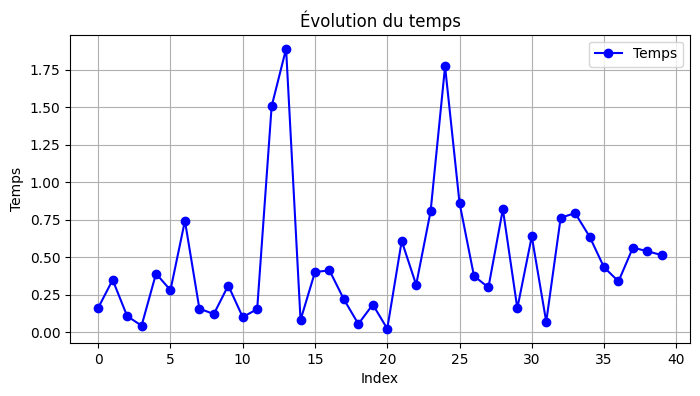

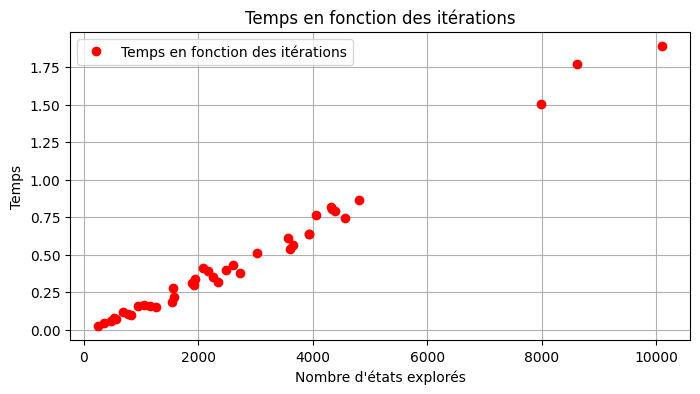

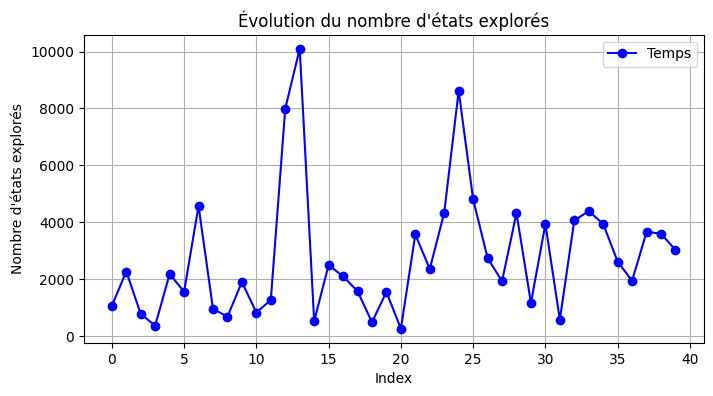

In [78]:
# 1. Tracer list_time seule
plt.figure(figsize=(8, 4))
plt.plot(list_timesBFS, marker='o', linestyle='-', color='b', label="Temps")
plt.xlabel("Index")
plt.ylabel("Temps")
plt.title("Évolution du temps")
plt.legend()
plt.grid(True)
plt.show()

# 2. Tracer list_time en fonction de list_iterations
plt.figure(figsize=(8, 4))
plt.plot(list_iterationsBFS, list_timesBFS, marker='o', linestyle='', color='r', label="Temps en fonction des itérations")
plt.xlabel("Nombre d'états explorés")
plt.ylabel("Temps")
plt.title("Temps en fonction des itérations")
plt.legend()
plt.grid(True)
plt.show()

# 3. Tracer list_iterations seule
plt.figure(figsize=(8, 4))
plt.plot(list_iterationsBFS, marker='o', linestyle='-', color='b', label="Temps")
plt.xlabel("Index")
plt.ylabel("Nombre d'états explorés")
plt.title("Évolution du nombre d'états explorés")
plt.legend()
plt.grid(True)
plt.show()

## Amélioration avec des heuristiques

### Question 8 - Pseudo-code : BFS avec files de priorité

### Question 9 - cf Rapport.

### Question 10 - Première heuristique

In [69]:

def heuristique0(self) -> int:
    # Heuristique triviale
    return 0


def heuristique1(self) -> int :
    # Heuristique du sujet : nombre de voitures bloquant la voiture rouge 
    
    vehicule = self.find_vehicule(1)
    x,y = vehicule["position"]
    length = vehicule["length"]

    nb_blocking_car = 0

    #On peut noter qu'il ne peut pas y avoir de voiture devant la voiture rouge dans la même orientation, donc chaque case occupée entre la voiture et la sortie correspond à une voiture différente. 
    if(vehicule["orientation"] == 'h'):
        for i in range(1, self.grid_size - x - (length - 1) ):
            if (self.grid[x + (length - 1)  + i][y]):
                nb_blocking_car += 1
    else:
        for i in range(1, self.grid_size - y - (length - 1) ):
            if (self.grid[x][y+(length - 1) +i]):
                nb_blocking_car += 1

    return nb_blocking_car

RushHourGame.heuristique0 = heuristique0
RushHourGame.heuristique1 = heuristique1

In [70]:
import heapq
from copy import deepcopy

total_time_solving = 0      
nb_iteration = 0

def astar_search(file_path, heuristic_index):
    compteur = 0    #permet d'introduire de l'unicité dans le heapq, l'heuristique sera d'abord comparée, puis la distance depuis l'origine puis le compteur (unique) car en cas d'égalité les instances de RushHourGame ne sont pas comparables 
    game = RushHourGame.parse_file(file_path, False)
    seen_config = {}  # Pour stocker les configurations déjà explorées
    g_costs = {}  # Stocke les coûts g(n) pour chaque état (les distances)

    global total_time_solving
    global nb_iteration

    temps = time.time()
    # Initialisation de l'état initial
    tuple_grid = tuple(tuple(sublist) for sublist in game.grid)
    seen_config[tuple_grid] = None
    g_costs[tuple_grid] = 0  # g(n) = 0 pour l'état initial
    
    priority_queue = []
    
    # Choix de l'heuristique
    def heuristique(self):
        if heuristic_index ==0:
            return self.heuristique0()
        elif heuristic_index ==1:
            return self.heuristique1()
        else:
            return self.heuristique2()
    RushHourGame.heuristique = heuristique
    
    heapq.heappush(priority_queue, (game.heuristique(), 0, compteur, game))  # (f, g, état)
    compteur += 1


    try:
        while priority_queue:
            _, g, _, game = heapq.heappop(priority_queue)  # Extraction du meilleur état

            if game.check_for_victory():
                raise ValueError("A solution has been found", (seen_config, game))
            
            next_moves = game.get_all_possible_moves()

            if next_moves is None:
                raise ValueError("There is a mistake somewhere", (seen_config, game))
            
            for move in next_moves:
               
                game.make_move(move["vehicule_id"], move["step"])
                
                tuple_grid = tuple(tuple(sublist) for sublist in game.grid)

                new_g = g + 1  # Chaque mouvement coûte 1

                if tuple_grid not in g_costs or new_g < g_costs[tuple_grid]:
                    nb_iteration += 1
                    g_costs[tuple_grid] = new_g
                    seen_config[tuple_grid] = move
    
                    new_game_instance = RushHourGame(game.grid_size, deepcopy(game.vehicles), deepcopy(game.grid), game.max_car_length, False)

                    f = new_g + new_game_instance.heuristique()
                    heapq.heappush(priority_queue, (f, new_g, compteur, new_game_instance))
                    compteur += 1
                
                # Annuler le mouvement pour tester les autres
                game.make_move(move["vehicule_id"], -move["step"])
                
    except ValueError as e:
        message, (seen_config, game_instance) = e.args
        print(message)
        #play_solution(reconstruct_solution(game_instance, seen_config), file_path)
    total_time_solving += time.time() - temps


In [71]:
list_iterationsH1 = []
list_timesH1 = []

for i in range(1, 41):
    nb_iteration = 0
    time_origin = time.time()

    if(i < 10):
        extension = '0' + str(i) + '.txt'
    else:
        extension = str(i) + '.txt'

    file_path = file_path_rad + extension
    astar_search(file_path, 1)
    list_iterationsH1.append(nb_iteration)
    list_timesH1.append(time.time() - time_origin)
    pygame.quit()

print("temps total : ", total_time_solving)
print("nombre d'itérations avec heuristique1 : ", sum(list_iterationsH1))

A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution h

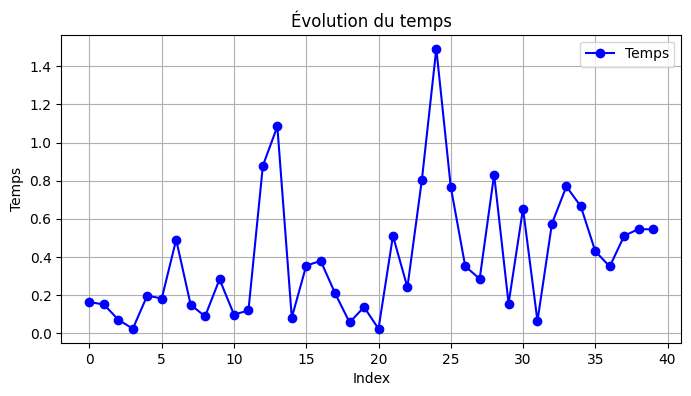

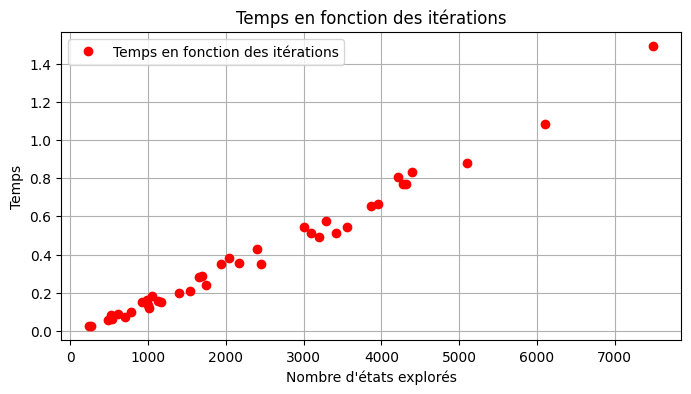

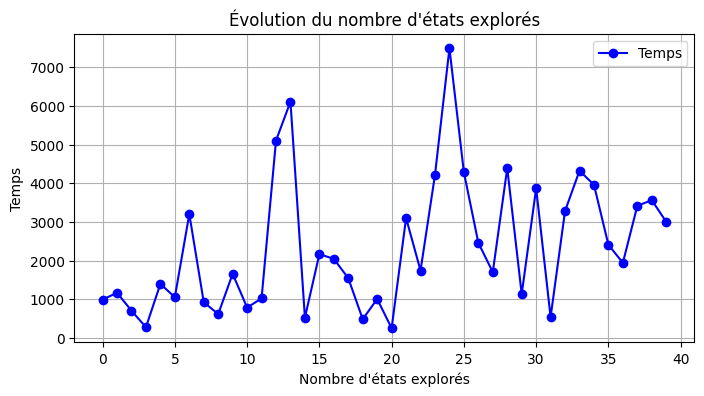

In [72]:
# 1. Tracer list_time seule
plt.figure(figsize=(8, 4))
plt.plot(list_timesH1, marker='o', linestyle='-', color='b', label="Temps")
plt.xlabel("Index")
plt.ylabel("Temps")
plt.title("Évolution du temps")
plt.legend()
plt.grid(True)
plt.show()

# 2. Tracer list_time en fonction de list_iterations
plt.figure(figsize=(8, 4))
plt.plot(list_iterationsH1, list_timesH1, marker='o', linestyle='', color='r', label="Temps en fonction des itérations")
plt.xlabel("Nombre d'états explorés")
plt.ylabel("Temps")
plt.title("Temps en fonction des itérations")
plt.legend()
plt.grid(True)
plt.show()

# 3. Tracer list_iterations seule
plt.figure(figsize=(8, 4))
plt.plot(list_iterationsH1, marker='o', linestyle='-', color='b', label="Temps")
plt.xlabel("Nombre d'états explorés")
plt.ylabel("Temps")
plt.title("Évolution du nombre d'états explorés")
plt.legend()
plt.grid(True)
plt.show()

### Question 11 - Heuristique au second ordre

In [73]:
def heuristique2(self) -> float:
        vehicule = self.find_vehicule(1)
        x,y = vehicule["position"]
        length = vehicule["length"]

        heuristique = 0

        #On peut noter qu'il ne peut pas y avoir devant la voiture rouge dans la même orientation, ainsi chaque case occupée entre la voiture et la sortie correspond à une voiture différente. 
        if(vehicule["orientation"] == 'h'):
            for i in range(1, self.grid_size - x - (length - 1) ):
                current_cell_content = self.grid[x + (length - 1)  + i][y]
                if current_cell_content:
                    heuristique += 1
                    blocking_vehicule = self.find_vehicule(current_cell_content)
                    up_move, down_move = blocking_vehicule["max_moves"]

                    if up_move + blocking_vehicule["position"][1] + blocking_vehicule["length"] - 1 >= y and down_move + blocking_vehicule["position"][1] <= y: 
                        heuristique += 1/self.max_car_length 

        else:
            for i in range(1, self.grid_size - y - (length - 1) ):
                current_cell_content = self.grid[x][y+(length - 1) +i]
                if current_cell_content:
                    heuristique += 1
                    blocking_vehicule = self.find_vehicule(current_cell_content)
                    left_move, right_move = blocking_vehicule["max_moves"]

                    if left_move + blocking_vehicule["position"][0] + blocking_vehicule["length"] >= x and right_move + blocking_vehicule["position"][1] <= x:
                        heuristique += 1/self.max_car_length
        
        return heuristique

RushHourGame.heuristique2 = heuristique2

In [74]:
list_iterationsH2 = []
list_timesH2 = []
total_time_solving = 0

for i in range(1, 41):
    nb_iteration = 0
    time_origin = time.time()

    if(i < 10):
        extension = '0' + str(i) + '.txt'
    else:
        extension = str(i) + '.txt'

    file_path = file_path_rad + extension
    astar_search(file_path, 2)
    list_iterationsH2.append(nb_iteration)
    list_timesH2.append(time.time() - time_origin)
    pygame.quit()

print("temps total : ", total_time_solving)
print("nombre d'itérations avec heuristique2 : ", sum(list_iterationsH2))

A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution has been found
A solution h

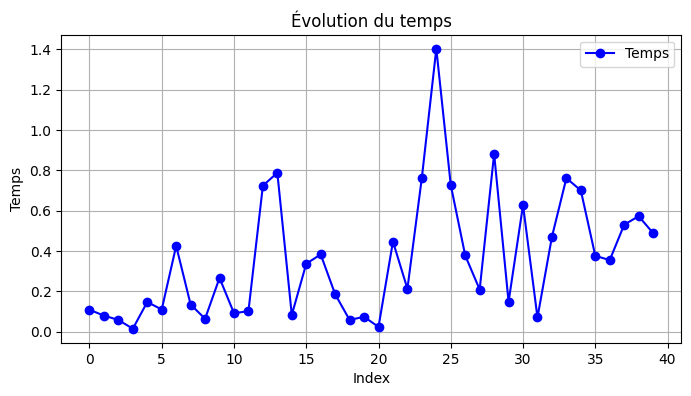

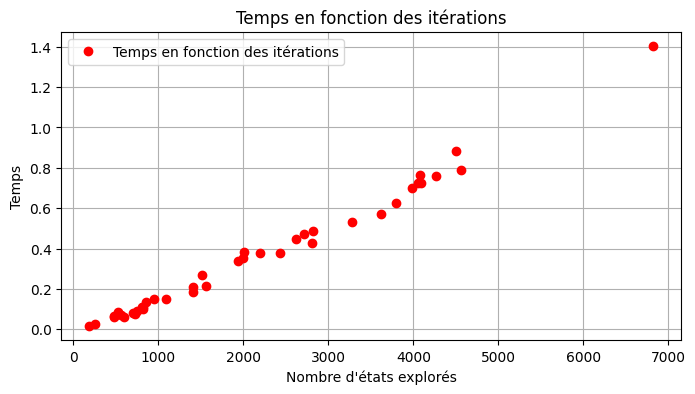

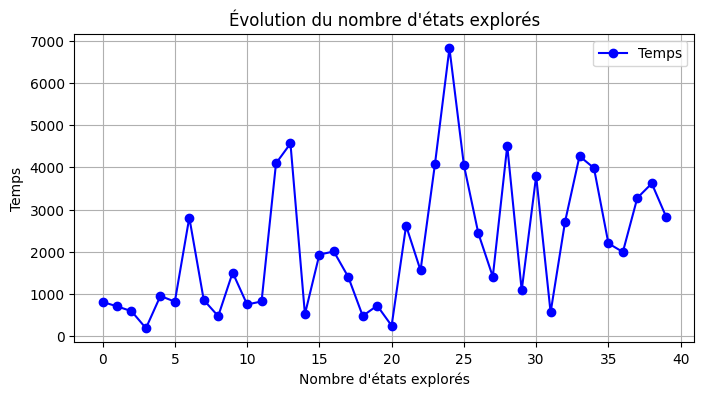

In [75]:
# 1. Tracer list_time seule
plt.figure(figsize=(8, 4))
plt.plot(list_timesH2, marker='o', linestyle='-', color='b', label="Temps")
plt.xlabel("Index")
plt.ylabel("Temps")
plt.title("Évolution du temps")
plt.legend()
plt.grid(True)
plt.show()

# 2. Tracer list_time en fonction de list_iterations
plt.figure(figsize=(8, 4))
plt.plot(list_iterationsH2, list_timesH2, marker='o', linestyle='', color='r', label="Temps en fonction des itérations")
plt.xlabel("Nombre d'états explorés")
plt.ylabel("Temps")
plt.title("Temps en fonction des itérations")
plt.legend()
plt.grid(True)
plt.show()

# 3. Tracer list_iterations seule
plt.figure(figsize=(8, 4))
plt.plot(list_iterationsH2, marker='o', linestyle='-', color='b', label="Temps")
plt.xlabel("Nombre d'états explorés")
plt.ylabel("Temps")
plt.title("Évolution du nombre d'états explorés")
plt.legend()
plt.grid(True)
plt.show()

### Comparaison des différentes heuristiques : 

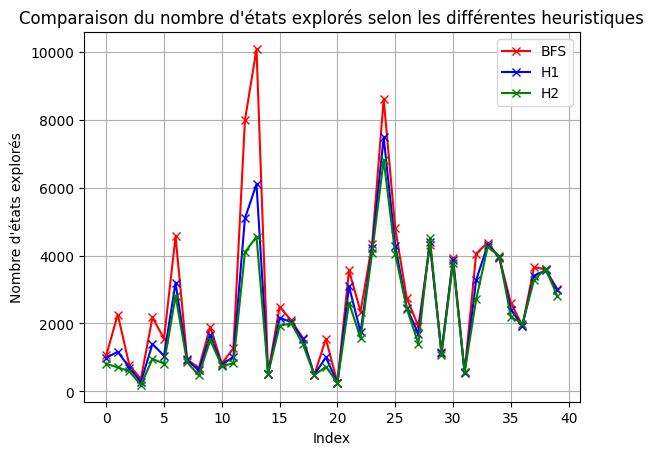

In [77]:
plt.plot(list_iterationsBFS, marker='x', linestyle='-', color='r', label="BFS")
plt.plot(list_iterationsH1, marker='x', linestyle='-', color='b', label="H1")
plt.plot(list_iterationsH2, marker='x', linestyle='-', color='g', label="H2")

# Ajouter des titres et légendes
plt.xlabel("Index")
plt.ylabel("Nombre d'états explorés")
plt.title("Comparaison du nombre d'états explorés selon les différentes heuristiques")
plt.legend()
plt.grid(True)

# Afficher le graphique
plt.show()

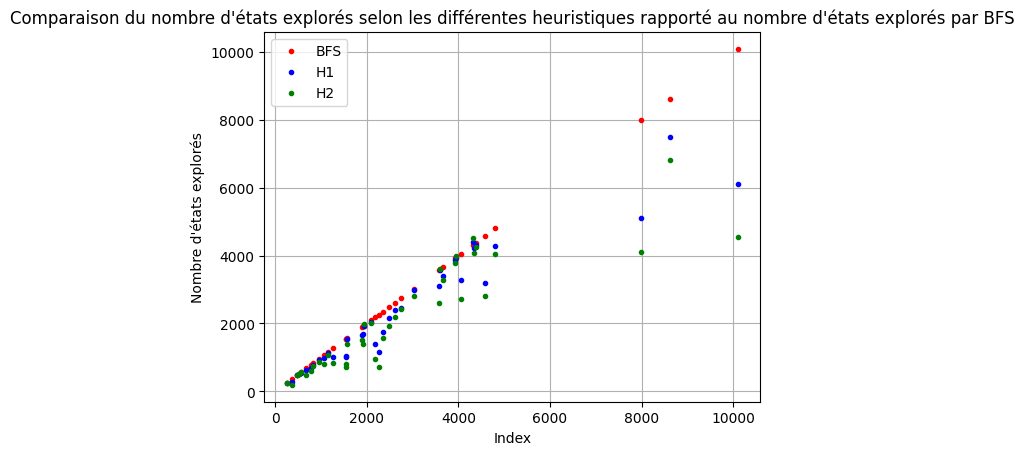

In [90]:
plt.plot(list_iterationsBFS, list_iterationsBFS, marker='o', linestyle='', color='r', label="BFS", markersize=3)
plt.plot(list_iterationsBFS, list_iterationsH1, marker='o', linestyle='', color='b', label="H1", markersize=3)
plt.plot(list_iterationsBFS, list_iterationsH2, marker='o', linestyle='', color='g', label="H2", markersize=3)

# Ajouter des titres et légendes
plt.xlabel("Index")
plt.ylabel("Nombre d'états explorés")
plt.title("Comparaison du nombre d'états explorés selon les différentes heuristiques rapporté au nombre d'états explorés par BFS")
plt.legend()
plt.grid(True)

# Afficher le graphique
plt.show()